# Neural Machine Translation

In this section we use the GloVe embedding in machine translation downstream task. We then preform dimensionality reduction on the embedding and perform the task again with smaller network.


## 1. Imports

In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip install --q wget

2023-08-16 15:57:03.503269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 15:57:04.415564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-16 15:57:05.892352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-16 15:57:05.892822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
# general
import io
import os
import gc
import time
import random
import warnings
from collections import Counter

# ML
import numpy as np
import pandas as pd
from sklearn.random_projection import SparseRandomProjection

# visual
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.optim as optim

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive

# metrics
from torchtext.data.metrics import bleu_score

# misc
import wget
import pickle
import zipfile

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6) # set default size of plots
sns.set_style('whitegrid')

In [ ]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

In [ ]:
# make sure you're using a GPU

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

## 2. Data Preparation

In [ ]:
base_url = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'

train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_files = [extract_archive(download_from_url(base_url + url))[0] for url in train_urls]
val_files = [extract_archive(download_from_url(base_url + url))[0] for url in val_urls]
test_files = [extract_archive(download_from_url(base_url + url))[0] for url in test_urls]

100%|██████████| 637k/637k [00:00<00:00, 11.8MB/s]
100%|██████████| 569k/569k [00:00<00:00, 6.49MB/s]
100%|██████████| 24.7k/24.7k [00:00<00:00, 2.22MB/s]
100%|██████████| 21.6k/21.6k [00:00<00:00, 2.83MB/s]
100%|██████████| 22.9k/22.9k [00:00<00:00, 2.12MB/s]
100%|██████████| 21.1k/21.1k [00:00<00:00, 2.65MB/s]


In [ ]:
test_de = iter(io.open(test_files[0], encoding='utf8'))
test_en = iter(io.open(test_files[1], encoding='utf8'))

test_df = pd.DataFrame(zip(test_en, test_de), columns=['En sentence', 'De sentence'])
test_df.head()

,En sentence,De sentence
0,A man in an orange hat starring at something.\n,"Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.\n"
1,A Boston Terrier is running on lush green grass in front of a white fence.\n,Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.\n
2,A girl in karate uniform breaking a stick with a front kick.\n,Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.\n
3,"Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.\n",Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.\n
4,People are fixing the roof of a house.\n,Leute Reparieren das Dach eines Hauses.\n


In [ ]:
def build_vocab(file, tokenizer):
    counter = Counter()
    with io.open(file, encoding='utf8') as f:
        for s in f:
            counter.update(tokenizer(s))
    v = vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    v.set_default_index(v['<unk>'])
    return v

In [ ]:
de_tokenizer = get_tokenizer('spacy', language='de')
en_tokenizer = get_tokenizer('spacy', language='en')

de_vocab = build_vocab(train_files[0], de_tokenizer)
en_vocab = build_vocab(train_files[1], en_tokenizer)

en_itos = en_vocab.get_itos()
de_itos = de_vocab.get_itos()
en_stoi = en_vocab.get_stoi()
de_stoi = de_vocab.get_stoi()

EN_VOCAB_SIZE = len(en_vocab)
DE_VOCAB_SIZE = len(de_vocab)

print(f'There are {EN_VOCAB_SIZE} tokens in the english vocabulary and {DE_VOCAB_SIZE} in the deutsch vocabulary.')

There are 10838 tokens in the english vocabulary and 19215 in the deutsch vocabulary.


In [ ]:
def transform_raw(vocab, tokenizer, raw_file):
    string_iter = iter(io.open(raw_file, encoding='utf8'))
    data = [torch.tensor([vocab[w] for w in tokenizer(s)]) for s in string_iter]
    return data

In [ ]:
de_train = transform_raw(de_vocab, de_tokenizer, train_files[0])
en_train = transform_raw(en_vocab, en_tokenizer, train_files[1])
train = list(zip(de_train, en_train))

de_val = transform_raw(de_vocab, de_tokenizer, val_files[0])
en_val = transform_raw(en_vocab, en_tokenizer, val_files[1])
val = list(zip(de_val, en_val))

de_test = transform_raw(de_vocab, de_tokenizer, test_files[0])
en_test = transform_raw(en_vocab, en_tokenizer, test_files[1])
test = list(zip(de_test, en_test))

## 3. Prepare Data Loaders

In [ ]:
BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

def preprocess_batch(batch):
    de_batch, en_batch = [], []
    for de_sentence, en_sentence in batch:
        de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_sentence, torch.tensor([EOS_IDX])], dim=0))
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_sentence, torch.tensor([EOS_IDX])], dim=0))

    de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)

    return (de_batch, en_batch)

train_iter = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=preprocess_batch)
val_iter = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=preprocess_batch)
test_iter = DataLoader(test, batch_size=1, shuffle=False, collate_fn=preprocess_batch)

## 4. Define the Network

In [ ]:
class Net(nn.Module):
    def __init__(self, embedding_dim=300):
        super(Net, self).__init__()

        size_factor = embedding_dim / 300

        self.en_embed = nn.Embedding(num_embeddings=EN_VOCAB_SIZE, embedding_dim=embedding_dim)
        self.de_embed = nn.Embedding(num_embeddings=DE_VOCAB_SIZE, embedding_dim=embedding_dim)
        self.transformer = nn.Transformer(d_model=embedding_dim, nhead=int(6 * size_factor),
            num_encoder_layers=2, num_decoder_layers=2, dropout=0.5, dim_feedforward=int(size_factor * 2048))
        self.fc1 = nn.Linear(embedding_dim, EN_VOCAB_SIZE)

    def forward(self, inputs, targets):
        x = self.de_embed(inputs)
        y = self.en_embed(targets)
        tgt_mask = torch.triu(torch.ones(targets.size(0), targets.size(0)), diagonal=1).bool().to(DEVICE)
        out = self.transformer(x, y, tgt_mask=tgt_mask)
        out = self.fc1(out.permute(1, 0, 2)) # (batch, sequence, feature)
        return out.permute(1, 0, 2).reshape(-1, EN_VOCAB_SIZE) # (sequence, batch, feature)

    def init_weights(self, en_weights=None, de_weights=None):
      if en_weights is not None:
        self.en_embed.weight.data.copy_(torch.from_numpy(en_weights))

      if de_weights is not None:
        self.de_embed.weight.data.copy_(torch.from_numpy(de_weights))


In [ ]:
def to_sentence(ts):
    """ Convert list of word-index to a sentence """
    return ' '.join([en_itos[x] for x in ts.squeeze() if x != PAD_IDX])


def eval_blue_score(net, max_output_len=50):
    """ Run the NMT model on the validation set, return the average bleu-score """
    losses = 0.
    scores = 0.
    cnt = 0
    net.eval()
    for inputs_batch, targets_batch in val_iter:
        for i in range(inputs_batch.size(1)):
            inputs, targets = inputs_batch[:,i:i+1], targets_batch[:,i:i+1]
            my_targets = targets[:1]
            while len(my_targets) < max_output_len and my_targets[-1] != en_vocab['<eos>']:
                pred = net(inputs.to(DEVICE), my_targets.to(DEVICE))
                my_targets = torch.cat((
                    my_targets,
                    pred[-1,].argmax().unsqueeze(dim=0).unsqueeze(dim=0).cpu()
                ))

            target_sentence = to_sentence(targets[1:-1])
            pred_sentence = to_sentence(my_targets[1:-1])
            score = bleu_score([pred_sentence.split()], [[target_sentence.split()]])
            scores += score
            cnt += 1

    return scores / cnt


def eval_loss(net, criterion):
    """ Fast (not accurate) evaluation on validation set, return average loss """
    losses = 0.

    net.eval()
    for i, (inputs, targets) in enumerate(val_iter):
        pred = net(inputs.to(DEVICE), targets[:-1,].to(DEVICE))

        loss = criterion(pred.cpu(), targets[1:,].view(-1))
        losses += loss.detach().item()

    return losses / (i+1)


## 5. Create the Embedding

In [ ]:
if not os.path.exists('glove.6B.zip'):
  wget.download('https://nlp.stanford.edu/data/glove.6B.zip')

with zipfile.ZipFile('glove.6B.zip', 'r') as f:
    f.extract('glove.6B.300d.txt')

if not os.path.exists('vectors.txt'):
  wget.download('https://int-emb-glove-de-wiki.s3.eu-central-1.amazonaws.com/vectors.txt')

In [ ]:
en_glove_weights = np.zeros((EN_VOCAB_SIZE, 300))

# for each word in our vocab with index i in the dict :
# add to the ith row of glove_weights the vector corresponding to that word
with open('glove.6B.300d.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
      values = line.split(' ')
      if values[0] in en_itos:
        id = en_stoi[values[0]]
        en_glove_weights[id] = np.array(values[1:])

In [ ]:
de_glove_weights = np.zeros((DE_VOCAB_SIZE, 300))

# for each word in our vocab with index i in the dict :
# add to the ith row of glove_weights the vector corresponding to that word
with open('vectors.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
      values = line.split(' ')
      if values[0] in de_itos:
        id = de_stoi[values[0]]
        de_glove_weights[id] = np.array(values[1:])

## 6. Training

In [ ]:
def train_network(net, epochs=10):
    metrics = {'train_loss': [], 'val_loss': [], 'val_blue': [], 'total_runtime':[]}
    net.to(DEVICE)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    optimizer = optim.Adam(net.parameters())

    net.train()
    start = time.time()
    for epoch in tqdm(range(epochs)):
        losses = 0.
        for i, (inputs, targets) in enumerate(train_iter):
            optimizer.zero_grad()
            pred = net(inputs.to(DEVICE), targets[:-1,].to(DEVICE))
            loss = criterion(pred.cpu(), targets[1:,].view(-1))
            loss.backward()
            optimizer.step()

            losses += loss.detach().item()

        metrics['train_loss'].append(losses / (i+1))
        metrics['val_loss'].append(eval_loss(net, criterion))
        metrics['val_blue'].append(eval_blue_score(net))
        metrics['total_runtime'].append(time.time() - start)

    return metrics

In [ ]:
base_line_model = Net(300)
base_line_model.init_weights(en_glove_weights, de_glove_weights)

In [ ]:
EPOCHS = 10

In [ ]:
if os.path.exists('base_res.pkl'):
  with open('base_res.pkl', 'rb') as f:
    base_line_metrics = pickle.load(f)
else:
  base_line_metrics = train_network(base_line_model, EPOCHS)
  with open('base_res.pkl', 'wb') as f:
    pickle.dump(base_line_metrics, f)

## 7. Running the Experiments

In [ ]:
def cssrpl(input_weights, output_dim, l=2, projection_matrix=None):
  if projection_matrix is None:
    projection_matrix = np.zeros((output_dim, 300))

    for col in range(output_dim):
      non_zero_indices = np.random.choice(output_dim, l)
      for row in non_zero_indices:
        projection_matrix[row, col] = np.random.randint(2) * 2 - 1


    return np.where(input_weights @ projection_matrix.T > 0, 1, 0), projection_matrix
  else:
    return np.where(input_weights @ projection_matrix.T > 0, 1, 0)

In [ ]:
dims = [300, 200, 150]

def run_experiment(dims, epochs=10):
  num_params = {}
  jlt_metrics = {}
  srp_metrics = {}
  for dim in dims:
    torch.cuda.empty_cache()
    gc.collect()

    model = Net(dim)
    num_params[dim] = sum(p.numel() for p in model.parameters())

    if dim == 300:
      continue

    # get JLT weights and init weights
    sp = SparseRandomProjection(n_components = dim)
    model.init_weights(sp.fit_transform(en_glove_weights), sp.fit_transform(de_glove_weights))

    jlt_metrics[dim] = train_network(model, epochs)

    del model
    torch.cuda.empty_cache()
    gc.collect()

    model = Net(dim)
    # get cssrpl weight and init weights
    reduced_en, proj = cssrpl(en_glove_weights, dim)
    reduced_de = cssrpl(de_glove_weights, dim, projection_matrix=proj)
    model.init_weights(reduced_en, reduced_de)

    srp_metrics[dim] = train_network(model, epochs)


  return num_params, jlt_metrics, srp_metrics


In [ ]:
if not os.path.exists('trans_res.pkl'):
  exp_results = run_experiment(dims, EPOCHS)

  with open('trans_res.pkl', 'wb') as f:
    pickle.dump(exp_results, f)
else:
  with open('trans_res.pkl', 'rb') as f:
    exp_results = pickle.load(f)


## 8. Results

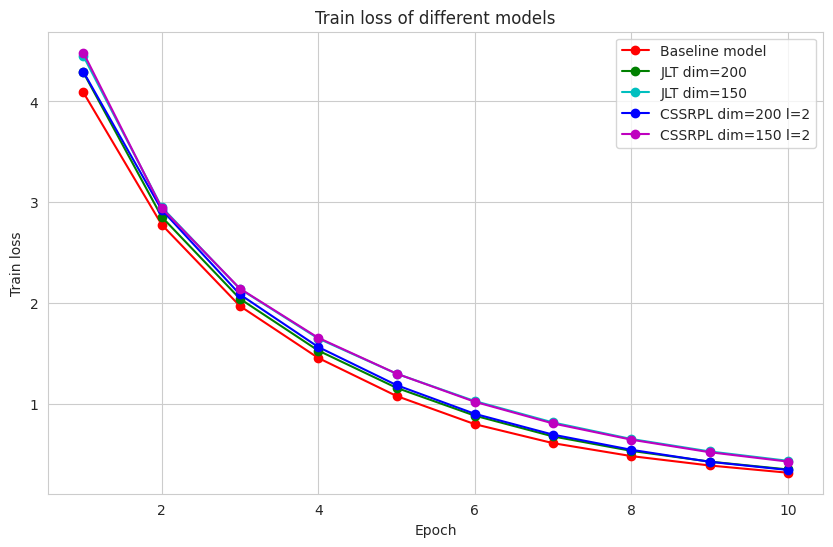

In [ ]:
epochs = np.arange(10) + 1
plt.plot(epochs, base_line_metrics['train_loss'], 'ro-')
plt.plot(epochs, exp_results[1][200]['train_loss'], 'go-')
plt.plot(epochs, exp_results[1][150]['train_loss'], 'co-')
plt.plot(epochs, exp_results[2][200]['train_loss'], 'bo-')
plt.plot(epochs, exp_results[2][150]['train_loss'], 'mo-')
plt.xlabel('Epoch')
plt.ylabel('Train loss')
plt.legend(['Baseline model', 'JLT dim=200', 'JLT dim=150', 'CSSRPL dim=200 l=2', 'CSSRPL dim=150 l=2'])
plt.title('Train loss of different models')
plt.show()

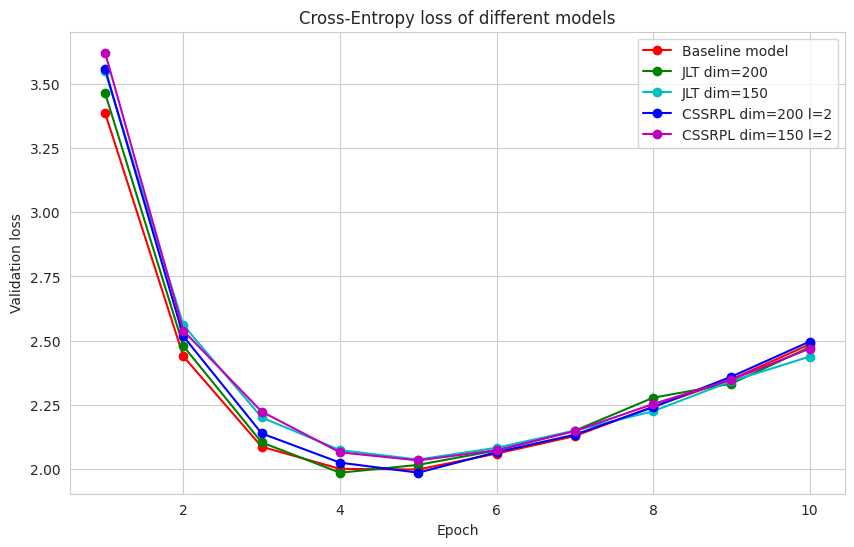

In [ ]:
plt.plot(epochs, base_line_metrics['val_loss'], 'ro-')
plt.plot(epochs, exp_results[1][200]['val_loss'], 'go-')
plt.plot(epochs, exp_results[1][150]['val_loss'], 'co-')
plt.plot(epochs, exp_results[2][200]['val_loss'], 'bo-')
plt.plot(epochs, exp_results[2][150]['val_loss'], 'mo-')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend(['Baseline model', 'JLT dim=200', 'JLT dim=150', 'CSSRPL dim=200 l=2', 'CSSRPL dim=150 l=2'])
plt.title('Cross-Entropy loss of different models')
plt.show()

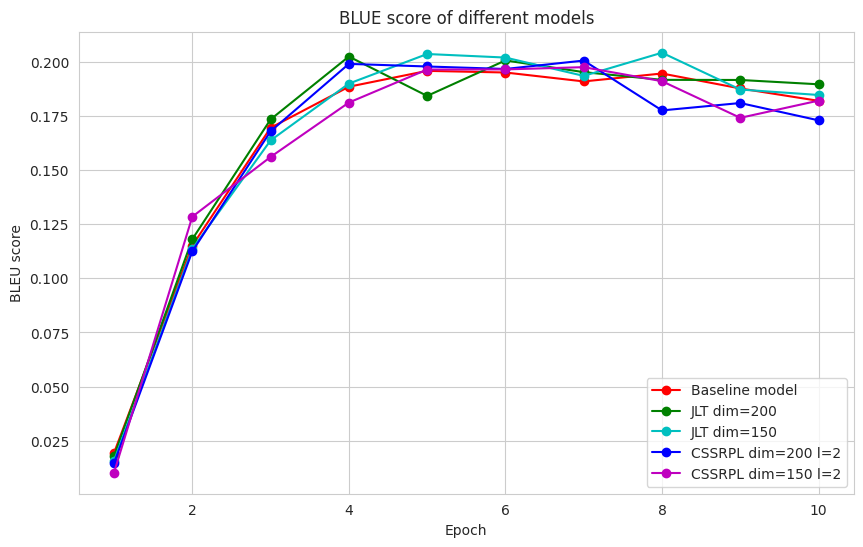

In [ ]:
plt.plot(epochs, base_line_metrics['val_blue'], 'ro-')
plt.plot(epochs, exp_results[1][200]['val_blue'], 'go-')
plt.plot(epochs, exp_results[1][150]['val_blue'], 'co-')
plt.plot(epochs, exp_results[2][200]['val_blue'], 'bo-')
plt.plot(epochs, exp_results[2][150]['val_blue'], 'mo-')
plt.xlabel('Epoch')
plt.ylabel('BLEU score')
plt.legend(['Baseline model', 'JLT dim=200', 'JLT dim=150', 'CSSRPL dim=200 l=2', 'CSSRPL dim=150 l=2'])
plt.title('BLUE score of different models')
plt.show()

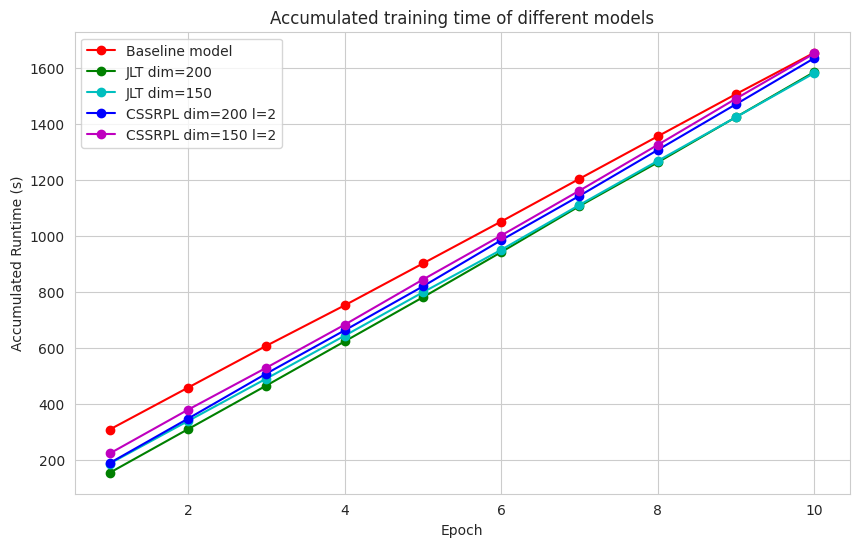

In [ ]:
plt.plot(epochs, base_line_metrics['total_runtime'], 'ro-')
plt.plot(epochs, exp_results[1][200]['total_runtime'], 'go-')
plt.plot(epochs, exp_results[1][150]['total_runtime'], 'co-')
plt.plot(epochs, exp_results[2][200]['total_runtime'], 'bo-')
plt.plot(epochs, exp_results[2][150]['total_runtime'], 'mo-')
plt.xlabel('Epoch')
plt.ylabel('Accumulated Runtime (s)')
plt.legend(['Baseline model', 'JLT dim=200', 'JLT dim=150', 'CSSRPL dim=200 l=2', 'CSSRPL dim=150 l=2'])
plt.title('Accumulated training time of different models')
plt.show()

In [ ]:
def test_model(net):
    """ Run the NMT model on the test set, show some example translation and average bleu-score """
    examples = []
    losses = 0.
    scores = 0.
    cnt = 0
    net.eval()
    for i, (inputs, targets) in enumerate(test_iter):
        my_targets = targets[:1]
        while len(my_targets) < 50 and my_targets[-1] != en_vocab['<eos>']:
            pred = net(inputs.to(DEVICE), my_targets.to(DEVICE))
            my_targets = torch.cat((
                my_targets,
                pred[-1,].argmax().unsqueeze(dim=0).unsqueeze(dim=0).cpu()
            ))

        target_sentence = to_sentence(targets[1:-1])
        pred_sentence = to_sentence(my_targets[1:-1])
        score = bleu_score([pred_sentence.split()], [[target_sentence.split()]])
        scores += score
        cnt += 1
        if i < 5:
            examples.append({'truth': target_sentence, 'pred': pred_sentence})

    return scores / cnt, examples


In [ ]:
def test_best():
  model1 = Net(300)
  model1.init_weights(en_glove_weights, de_glove_weights)

  train_network(model1, 8)

  acc1, examples1 = test_model(model1)
  del model1
  torch.cuda.empty_cache()
  gc.collect()

  # best JLT
  model2 = Net(150)
  sp = SparseRandomProjection(n_components=150)
  model2.init_weights(sp.fit_transform(en_glove_weights), sp.fit_transform(de_glove_weights))

  train_network(model2, 8)

  acc2, examples2 = test_model(model2)
  del model2
  torch.cuda.empty_cache()
  gc.collect()

  # best CSSRPL
  model3 = Net(200)
  reduced_en, proj = cssrpl(en_glove_weights, 200)
  reduced_de = cssrpl(de_glove_weights, 200, projection_matrix=proj)
  model3.init_weights(reduced_en, reduced_de)

  train_network(model3, 7)

  acc3, examples3 = test_model(model3)
  del model3
  torch.cuda.empty_cache()
  gc.collect()

  return [acc1, acc2, acc3], [examples1, examples2, examples3]


In [ ]:
accs, examples = test_best()

100%|██████████| 7/7 [18:48<00:00, 161.24s/it]


In [ ]:
df = pd.DataFrame({'Model Type': ['Baseline', 'with JLT', 'with CSSRPL'],
                   'Dimension': [300, 150, 200],
                   'Num of model params': [f'{exp_results[0][300] / 10e6:.2f}M', f'{exp_results[0][150] / 10e6:.2f}M', f'{exp_results[0][200] / 10e6:.2f}M'],
                   'Training epochs': [8, 8, 7],
                   'Ave. epoch duration': ['198.94s', '156.99s', '161.24s'],
                   'Test set BLUE score': accs})
df.to_csv('nmt_results.csv')
df.head()

,Model Type,Dimension,Num of model params,Training epochs,Ave. epoch duration,Test set BLUE score
0,Baseline,300,1.94M,8,198.94s,0.193265
1,with JLT,150,0.79M,8,156.99s,0.206831
2,with CSSRPL,200,1.13M,7,161.24s,0.210783


In [ ]:
for example, model_type in zip(examples, ['baseline', 'jlt', 'cssrpl']):
  print(f'Model type is: {model_type}. Example translations:\n')
  for e in example:
    print(f'True sentence:\n{e["truth"]}Pred sentence:\n{e["pred"]}')
  print('\n')

Model type is: baseline. Example translations:

True sentence:
A man in an orange hat starring at something . 
Pred sentence:
A man in an orange hat , orange hat , overalls , cleaning something . 

True sentence:
A Boston Terrier is running on lush green grass in front of a white fence . 
Pred sentence:
A Boston player walks along white fence behind his white fence . 

True sentence:
A girl in karate uniform breaking a stick with a front kick . 
Pred sentence:
A girl in a karate uniform is hitting a kick with a t - shirt . 

True sentence:
Five people wearing winter jackets and helmets stand in the snow , with <unk> in the background . 
Pred sentence:
Five people in their helmets with mountains in the snow surrounding . 

True sentence:
People are fixing the roof of a house . 
Pred sentence:
People on the side of a building . 



Model type is: jlt. Example translations:

True sentence:
A man in an orange hat starring at something . 
Pred sentence:
A man with an orange hat is 

True se